# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        assert (epsilon >= 0 and epsilon <= 1)
        assert (type(narms) == int and narms > 0)
        self.epsilon = epsilon
        self.narms = narms
        self.armCounts = np.zeros(narms, dtype=np.int)
        self.Q = np.full(narms, Q0, dtype=np.float)
        self.tround = 1
        
    def play(self, tround, context=None):
        rand = np.random.random()        
        if (rand < self.epsilon): #randomly pick an arm given the probability of epsilon
            arm = np.random.randint(self.narms)+ 1
        else:
            arm = np.random.choice(np.flatnonzero(self.Q == self.Q.max())) + 1
        return arm
        
    def update(self, arm, reward, context=None):
        self.armCounts[arm-1] += 1
        if self.Q[arm-1] == np.inf: #the first time an arm is choosen, the Q value will be the reward
            self.Q[arm-1] = reward
        else:
            self.Q[arm-1] += (1./self.armCounts[arm-1]) * (reward - self.Q[arm-1])
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        assert (type(narms) == int and narms > 0)
        assert (rho > 0)
        self.rho = rho
        self.narms = narms
        self.armCounts = np.zeros(narms, dtype=np.int)
        self.u = np.full(narms, Q0, dtype=np.float)
        self.tround = 1
        self.Q = np.full(narms, Q0, dtype=np.float)
        
    def play(self, tround, context=None):
        for i in range(self.narms):
            if self.armCounts[i] == 0: #if the arm is never played, there is no need to update Q value
                continue
            else:
                bound = np.sqrt(float(self.rho * np.log(tround)) / float(self.armCounts[i]))
                self.Q[i] = self.u[i] + bound
        arm = np.random.choice(np.flatnonzero(self.Q == self.Q.max())) + 1
        return arm
        
    def update(self, arm, reward, context=None):
        self.armCounts[arm-1] += 1
        if self.u[arm-1] == np.inf: #the first time an arm is choosen, the Q value will be the reward
            self.u[arm-1] = reward
        else:
            self.u[arm-1] += (1./self.armCounts[arm-1]) * (reward - self.u[arm-1])

## 2. Off-Policy Evaluation

In [5]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    per_round_reward = []
    rewardCounts = np.zeros(mab.narms, dtype=np.int)
    if nrounds is None: #if the number of round is not given, it will be set as infinity
        nrounds = np.inf
    for i, arm in enumerate(arms):
        if arm == mab.play(mab.tround, contexts[i:i+1,:]): #the choose arm matches with the event
            mab.update(arm, rewards[i], contexts[i:i+1,:])
            rewardCounts[arm-1] += rewards[i]
            per_round_reward.append(rewards[i])
            mab.tround += 1
            if mab.tround > nrounds:
                return np.asarray(per_round_reward)
        else: #the choose arm does not match, the event is discarded 
            continue
    return np.asarray(per_round_reward)


In [6]:
# read the data
data = np.loadtxt('dataset.txt')
arms = data[:,0].astype(int)
rewards = data[:,1].astype(float)
contexts = data[:,2:].astype(float)

In [7]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.2275


In [8]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.19125


## 3. Contextual Bandits

In [9]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        assert (type(narms) == int and narms > 0)
        assert (type(ndims) == int and ndims > 0)
        assert (alpha >= 0)
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.armCounts = np.zeros(narms, dtype=np.int)
        self.armRewards = np.zeros(narms, dtype=np.int)
        self.Alist = [np.identity(ndims)]*narms
        self.blist = [np.zeros((ndims, 1), dtype=np.float)]*narms
        self.p = np.zeros(narms, dtype=np.float)
        self.tround = 1
        
    def play(self, tround, context):
        for i in range(self.narms): #update p value of each arm before choosing an arm
            feature = context[:,i*self.ndims:(i+1)*self.ndims].reshape(10,1)
            theta = np.dot(inv(self.Alist[i]), self.blist[i])
            fst = np.dot(np.transpose(theta), feature)
            snd = self.alpha * ((np.transpose(feature).dot(inv(self.Alist[i])).dot(feature)) ** (1/2))
            self.p[i] = fst + snd
        arm = np.random.choice(np.flatnonzero(self.p == self.p.max())) + 1
        return arm
        
    def update(self, arm, reward, context):
        self.armCounts[arm-1] += 1
        self.armRewards[arm-1] += reward
        feature = context[:,(arm-1)*self.ndims:arm*self.ndims].reshape(10,1)
        self.Alist[arm-1] = self.Alist[arm-1] + np.dot(feature, np.transpose(feature))
        self.blist[arm-1] = self.blist[arm-1] + reward * feature

In [10]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Evaluation
### 4.A.

Text(0,0.5,'per-round cumulative reward')

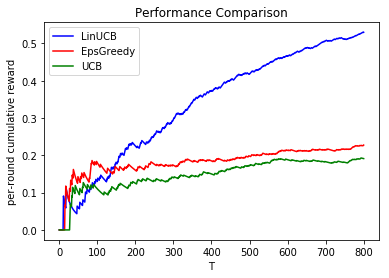

In [11]:
T_list = [0]
UCB_list = [0]
e_greedy_list = [0]
LinUCB_list = [0]
for i in range(800):
    UCB_list.append(sum(results_UCB[:(i+1)]/(i+1)))
    e_greedy_list.append(sum(results_EpsGreedy[:(i+1)]/(i+1)))
    LinUCB_list.append(sum(results_LinUCB[:(i+1)]/(i+1)))
    T_list.append(i+1)
plt.title('Performance Comparison')
plt.plot(T_list, LinUCB_list, color='blue', label='LinUCB')
plt.plot(T_list, e_greedy_list, color='red', label='EpsGreedy')
plt.plot(T_list, UCB_list, color='green', label='UCB')
plt.legend()
plt.xlabel('T')
plt.ylabel('per-round cumulative reward')

### 4.B.

Best alpha is 0.02, with average reward 0.73125


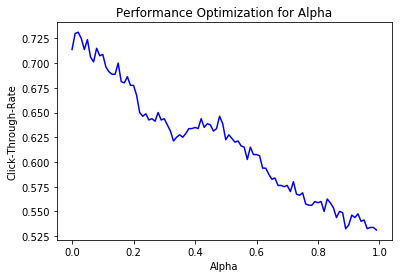

In [12]:
alpha_list = []
result_list = []
alpha = 0.0
max_alpha = alpha
max_CTR = 0.0
while alpha <= 1.0:
    mab = LinUCB(10, 10, alpha)
    result = offlineEvaluate(mab, arms, rewards, contexts, 800)
    alpha_list.append(alpha)
    result_list.append(np.mean(result))
    if np.mean(result) > max_CTR:
        max_CTR = np.mean(result)
        max_alpha = alpha
    alpha += 0.01
plt.title('Performance Optimization for Alpha')
plt.plot(alpha_list, result_list, color='blue')
plt.xlabel('Alpha')
plt.ylabel('Click-Through-Rate')
print('Best alpha is {}, with average reward {}'.format(max_alpha, max_CTR))

## 5. KernelUCB

In [13]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [14]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        assert (type(narms) == int and narms > 0)
        assert (type(ndims) == int and ndims > 0)
        self.narms = narms
        self.ndims = ndims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.armCounts = np.zeros(narms, dtype=np.int)
        self.tround = 1
        self.u = np.zeros(narms, dtype=np.float).reshape(10,1)
        self.u[0] = 1.0
        self.y_list = []
        self.x_list = []
        self.K_inv_list = []
        self.hist_k = []
    
    def play(self, tround, context):
        if tround == 1:
            arm = np.random.choice(np.flatnonzero(self.u == self.u.max())) + 1
            return arm
        else:
            for i in range(self.narms):
                feature_n = context[:,i*self.ndims:(i+1)*self.ndims]
                k_n_list = []
                for j in range(self.tround-1):
                    k_n_list.append(self.kern(feature_n, self.x_list[j])[0])
                    k_n = np.asarray(k_n_list)
                sigma = (self.kern(feature_n, feature_n) - np.transpose(k_n).dot(self.K_inv_list[self.tround-2]).dot(k_n)) ** (1/2)
                self.u[i] = np.transpose(k_n).dot(self.K_inv_list[self.tround-2]).dot(np.transpose(np.asarray(self.y_list))) + (self.eta / (self.gamma ** (1/2))) * sigma
            arm = np.random.choice(np.flatnonzero(self.u == self.u.max())) + 1
            return arm
    
    def update(self, arm, reward, context):
        self.armCounts[arm-1] += 1
        feature = context[:,(arm-1)*self.ndims:arm*self.ndims]
        self.x_list.append(feature)
        self.y_list.append(reward)
        k_list = []
        for i in range(self.tround):
            k_list.append(self.kern(feature, self.x_list[i])[0])
        k = np.asarray(k_list)
        self.hist_k.append(k)
        if self.tround == 1:
            K_inv = inv(self.kern(feature, feature) + self.gamma)
            self.K_inv_list.append(K_inv)
        else:
            b = self.hist_k[self.tround-2]
            K22 = inv(self.kern(feature, feature) + self.gamma - np.transpose(b).dot(self.K_inv_list[self.tround-2]).dot(b))
            K11 = self.K_inv_list[self.tround-2] + K22*(self.K_inv_list[self.tround-2].dot(b).dot(np.transpose(b)).dot(self.K_inv_list[self.tround-2]))
            K12 = - K22*(self.K_inv_list[self.tround-2].dot(b))
            K21 = - K22*(np.transpose(b).dot(self.K_inv_list[self.tround-2]))
            first_part = np.vstack((K11, K21))
            second_part = np.vstack((K12, K22))
            K_inv = np.hstack((first_part, second_part))
            self.K_inv_list.append(K_inv)
    

In [15]:
mab = KernelUCB(10, 10, 400, 10, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.43125


Text(0,0.5,'per-round cumulative reward')

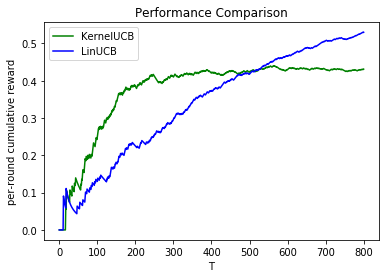

In [16]:
KernelUCB_list = [0]
LinUCB_list = [0]
T_list = [0]
for i in range(800):
    KernelUCB_list.append(sum(results_KernelUCB[:(i+1)]/(i+1)))
    LinUCB_list.append(sum(results_LinUCB[:(i+1)]/(i+1)))
    T_list.append(i+1)
plt.title('Performance Comparison')
plt.plot(T_list, KernelUCB_list, color='green', label='KernelUCB')
plt.plot(T_list, LinUCB_list, color='blue', label='LinUCB')
plt.legend()
plt.xlabel('T')
plt.ylabel('per-round cumulative reward')